In [2]:
# Cell 1 - imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import librosa
import librosa.display

sns.set(style="whitegrid")
%matplotlib inline
print("Libraries imported.")


Libraries imported.


In [3]:
# Cell 2 - load dataset (change path if needed)
DATA_PATH = "data/features_30_sec.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Put the CSV in the data/ folder.")

df = pd.read_csv(DATA_PATH)
print("Raw dataset shape:", df.shape)
display(df.head())


Raw dataset shape: (1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
# Cell 3 - clean dataset
df = df.copy()

# Drop filename column if present (not used for ML)
if "filename" in df.columns:
    df = df.drop(columns=["filename"])

# Drop rows with any NA
df = df.dropna().reset_index(drop=True)

# Ensure label column exists
if "label" not in df.columns:
    raise KeyError("No 'label' column found in CSV.")

# Keep only numeric feature columns + label
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
df_clean = df[numeric_cols + ["label"]].copy()

print("Cleaned dataset shape:", df_clean.shape)
display(df_clean.head())

# Save cleaned CSV for reuse
CLEAN_PATH = "data/cleaned_features_30_sec.csv"
df_clean.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned CSV to", CLEAN_PATH)


Cleaned dataset shape: (1000, 59)


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Saved cleaned CSV to data/cleaned_features_30_sec.csv


Unique genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


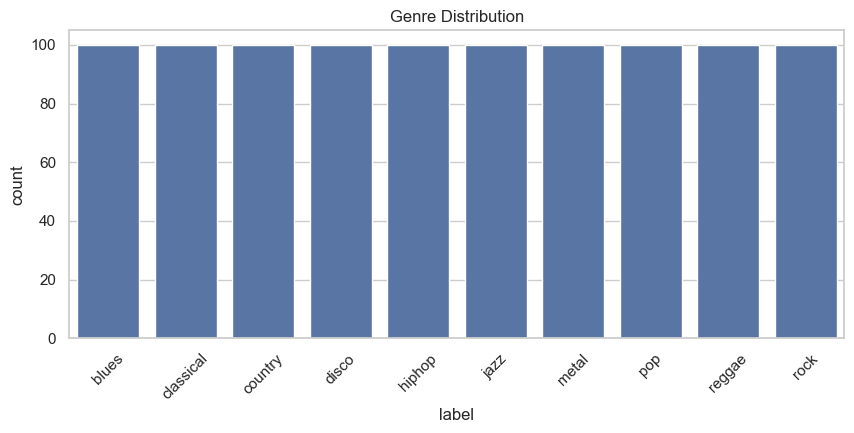

In [5]:
# Cell 4 - EDA
print("Unique genres:", df_clean["label"].unique())
plt.figure(figsize=(10,4))
sns.countplot(x=df_clean["label"], order=df_clean["label"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Genre Distribution")
plt.show()


In [6]:
# Cell 5 - features/labels split
X = df_clean.drop(columns=["label"])
y = df_clean["label"].copy()

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

# Stratified split
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)

print("Train rows:", X_train_df.shape[0], "Test rows:", X_test_df.shape[0])


Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Train rows: 800 Test rows: 200


In [7]:
# Cell 6 - scaling
scaler = StandardScaler()
scaler.fit(X_train_df)           # fit on training features (DataFrame ok)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

print("Scaling done. X_train shape:", X_train.shape)


Scaling done. X_train shape: (800, 58)


In [8]:
# Cell 7 - train model
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Training completed.")

# Predictions
y_pred = model.predict(X_test)

# Overall accuracy (percentage)
overall_acc = accuracy_score(y_test, y_pred) * 100
print(f"Overall Genre Accuracy: {overall_acc:.2f}%")

# Classification report (dictionary)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
print("\nClassification report (per genre):")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Training completed.
Overall Genre Accuracy: 78.00%

Classification report (per genre):
              precision    recall  f1-score   support

       blues       0.83      0.75      0.79        20
   classical       0.83      0.95      0.88        20
     country       0.70      0.80      0.74        20
       disco       0.75      0.60      0.67        20
      hiphop       0.67      0.80      0.73        20
        jazz       0.76      0.80      0.78        20
       metal       0.89      0.85      0.87        20
         pop       0.85      0.85      0.85        20
      reggae       0.76      0.80      0.78        20
        rock       0.80      0.60      0.69        20

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



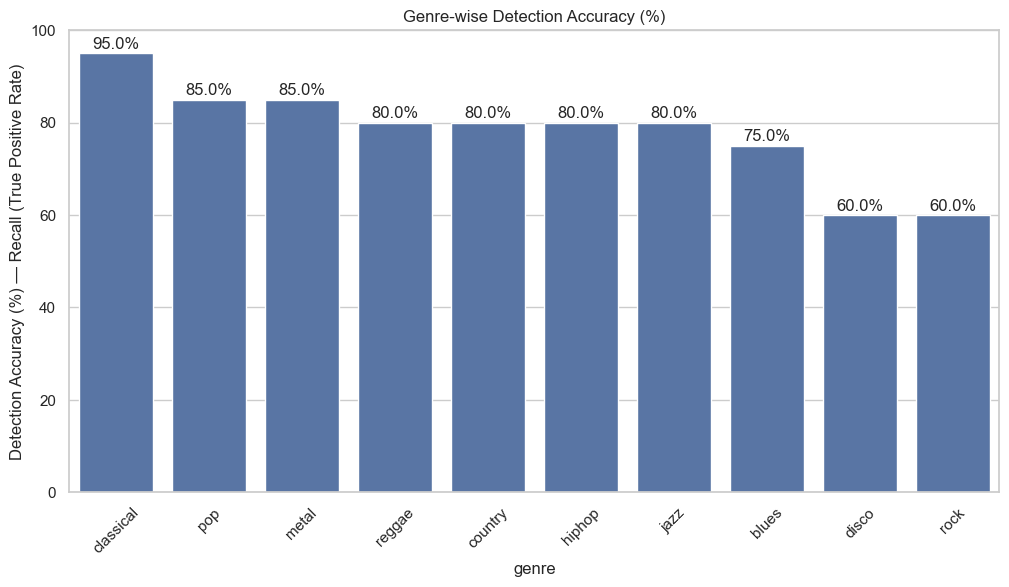

In [9]:
# Cell 8 - genre-wise accuracy percentages and bar chart
genre_names = list(le.classes_)
genre_acc = []

# We'll use per-genre recall as the 'how many of true genre were correctly detected'
for g in genre_names:
    genre_acc.append(report[g]["recall"] * 100)  # recall = correctly detected among true

# Create DataFrame for plotting
acc_df = pd.DataFrame({"genre": genre_names, "accuracy_percent": genre_acc}).sort_values("accuracy_percent", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=acc_df, x="genre", y="accuracy_percent")
plt.xticks(rotation=45)
plt.ylabel("Detection Accuracy (%) — Recall (True Positive Rate)")
plt.ylim(0, 100)
plt.title("Genre-wise Detection Accuracy (%)")
for i,row in acc_df.iterrows():
    plt.text(x=list(acc_df.genre).index(row.genre), y=row.accuracy_percent+1, s=f"{row.accuracy_percent:.1f}%", ha='center')
plt.show()


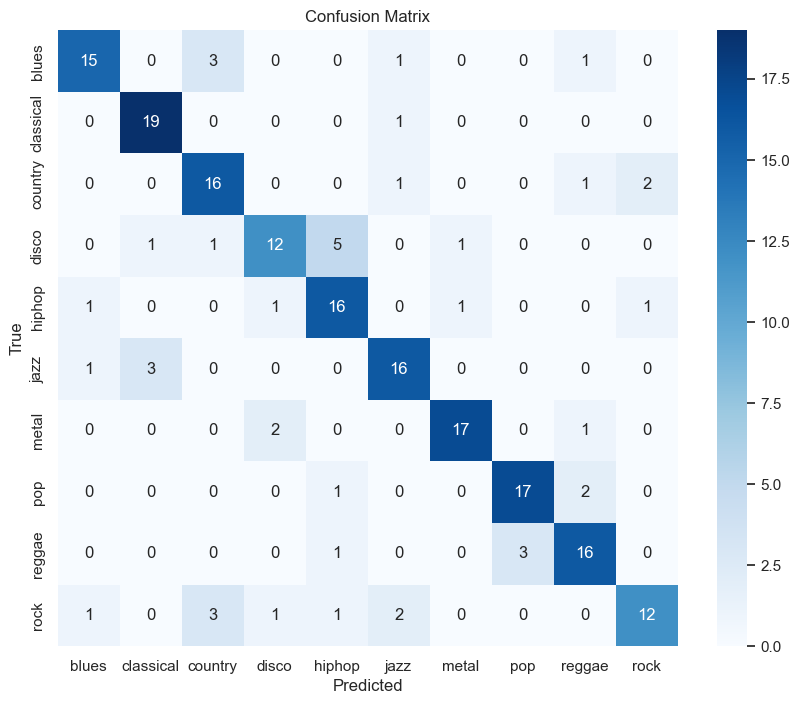

In [10]:
# Cell 9 - confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


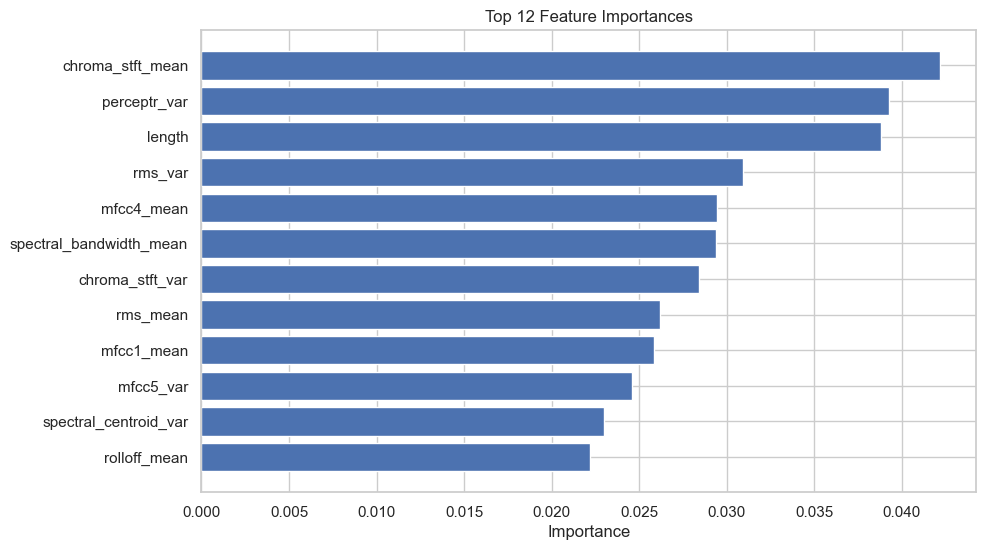

In [11]:
# Cell 10 - feature importances
importances = model.feature_importances_
feat_names = X.columns.to_list()
top_n = 12
indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances")
plt.show()


In [12]:
# Cell 11 - recommendation function
genre_to_mood = {
    'pop': 'happy', 'rock': 'energetic', 'metal': 'aggressive', 'blues': 'sad',
    'country': 'calm', 'disco': 'happy', 'hiphop': 'excited',
    'classical': 'peaceful', 'reggae': 'chill', 'jazz': 'calm'
}

def recommend_songs(df_full, scaler_obj, model_obj, mood, top_n=5):
    # df_full should be original cleaned df (with label)
    df_local = df_full.copy()
    df_local["mood"] = df_local["label"].map(genre_to_mood)
    mood_df = df_local[df_local["mood"] == mood]
    if mood_df.empty:
        print("No songs for mood:", mood)
        return pd.DataFrame()
    # pick a random reference (use its index in df_local)
    ref_idx = mood_df.sample(1).index[0]
    # prepare features (scaled)
    features_all = scaler_obj.transform(df_local.drop(columns=["label", "mood"]))
    ref_vec = features_all[ref_idx].reshape(1, -1)
    sims = cosine_similarity(ref_vec, features_all).flatten()
    ranked = np.argsort(-sims)
    ranked = [i for i in ranked if i != ref_idx]  # exclude itself
    top_idx = ranked[:top_n]
    results = df_local.iloc[top_idx][["label"]].copy()
    results["similarity_score"] = sims[top_idx]
    results["mood"] = df_local["mood"].iloc[top_idx].values
    results["filename"] = df_local.index[top_idx].map(lambda i: None)  # placeholder if filename missing
    return results.reset_index(drop=True)

# Example usage (with cleaned df saved earlier)
df_for_rec = pd.read_csv(CLEAN_PATH)
rec = recommend_songs(df_for_rec, scaler, model, "happy", top_n=5)
display(rec)


,label,similarity_score,mood,filename
0,disco,0.829258,happy,None
1,disco,0.829079,happy,None
2,reggae,0.797659,chill,None
3,rock,0.772558,energetic,None
4,country,0.720674,calm,None


Loaded: data/genres_original/blues/blues.00081.wav
SR: 22050 Duration (s): 30.0


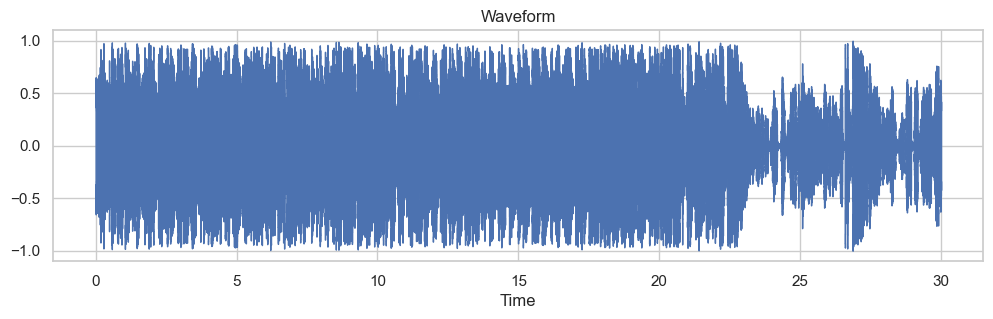

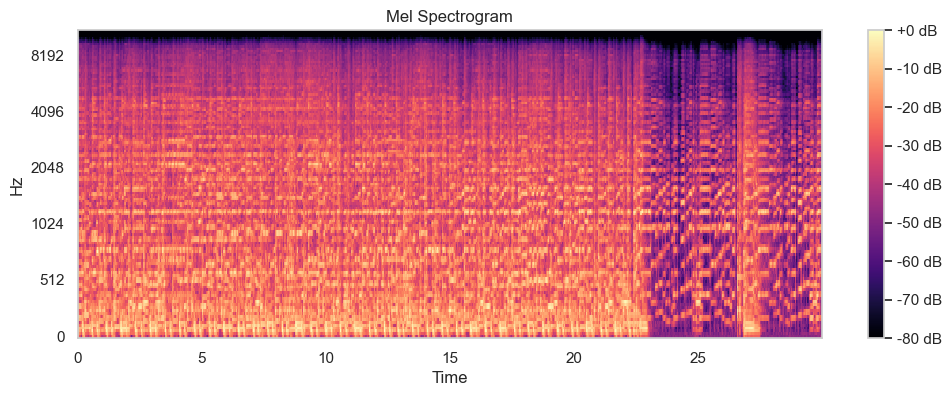

Predicted Genre: metal
Predicted Mood: aggressive


c:\Users\Khushi\Downloads\ML_Project\MusicGenreClassifier\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
# Cell 12 - audio demo (uses genres_original WAVs)
audio_path = r"data/genres_original/blues/blues.00081.wav"  # change to any file in your genres_original

# load audio (use 30s or shorter)
y, sr = librosa.load(audio_path, duration=30)
print("Loaded:", audio_path)
print("SR:", sr, "Duration (s):", librosa.get_duration(y=y, sr=sr))

# waveform
plt.figure(figsize=(12,3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

# mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
Sdb = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# play audio
ipd.display(ipd.Audio(y, rate=sr))

# extract features using same feature columns as X (mean MFCC/chroma/... assumed)
# Simple approach: compute MFCC means for the first len_MFCC features if present
# We'll attempt to build a feature vector matching X.columns length:
def extract_basic_features_from_audio(y, sr, ref_columns):
    # compute some features and then align into array with zeros for missing
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_mean = np.mean(spec_contrast, axis=1)
    vec = np.hstack([mfcc_mean, chroma_mean, spec_mean])
    # If X has different layout, user should adapt; here we try to match length
    if len(vec) >= len(ref_columns):
        vec = vec[:len(ref_columns)]
    else:
        # pad with zeros
        vec = np.concatenate([vec, np.zeros(len(ref_columns)-len(vec))])
    return vec

# build and predict
ref_columns = X.columns.to_list()
sample_vec = extract_basic_features_from_audio(y, sr, ref_columns)
sample_scaled = scaler.transform([sample_vec])
pred_idx = model.predict(sample_scaled)[0]
pred_label = le.inverse_transform([pred_idx])[0]
pred_mood = genre_to_mood.get(pred_label, "unknown")
print("Predicted Genre:", pred_label)
print("Predicted Mood:", pred_mood)


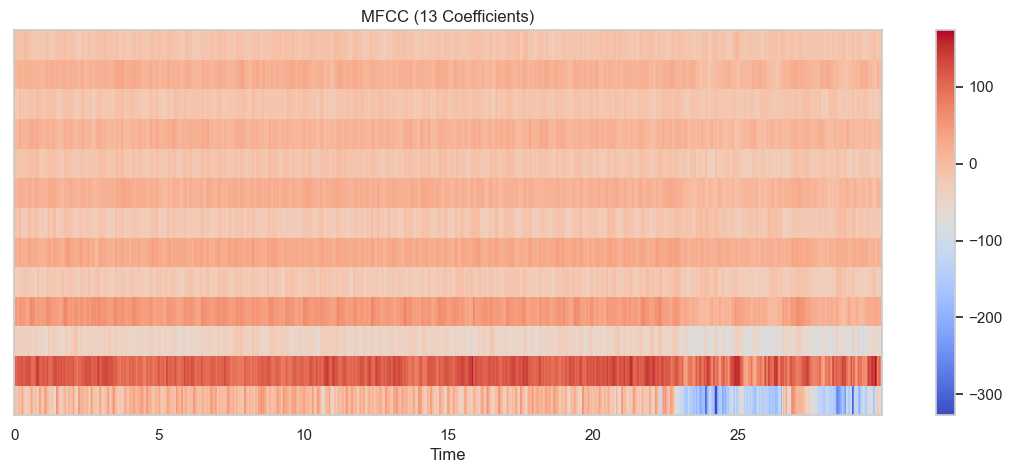

In [18]:
#MFCC Plot (13 Coefficients) of blue
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC (13 Coefficients)")
plt.show()


In [16]:
# 🎯 FINAL CELL — USER GENRE PREDICTION + RECOMMENDATIONS + ACCURACY

print("🎵 FINAL MODEL PREDICTION & RECOMMENDATION TEST 🎵\n")

# 1️⃣ Overall accuracy (already trained)
from sklearn.metrics import accuracy_score

y_pred_final = model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final) * 100
print(f"✅ Model Accuracy: {final_accuracy:.2f}%\n")

# 2️⃣ Take any user-like feature (simulating user input)
# Example: take row 15 from dataset as user input
user_features = X.iloc[15].values

# 3️⃣ Predict genre and mood
def final_predict_genre_and_mood(features):
    # Convert to DataFrame
    feat_df = pd.DataFrame([features], columns=X.columns)
    
    # Scale
    scaled = scaler.transform(feat_df)

    # Predict genre
    pred_index = model.predict(scaled)[0]
    pred_genre = le.inverse_transform([pred_index])[0]

    # Map mood
    pred_mood = genre_to_mood.get(pred_genre, "unknown")
    return pred_genre, pred_mood

predicted_genre, predicted_mood = final_predict_genre_and_mood(user_features)

print("🎧 USER INPUT PREDICTION")
print("Predicted Genre :", predicted_genre)
print("Predicted Mood  :", predicted_mood)

# 4️⃣ Recommendations based on predicted mood
print("\n🎶 Recommended Songs Based on Your Mood:", predicted_mood)
try:
    recs = recommend_songs(df, scaler, predicted_mood, top_n=5)
    display(recs)
except:
    print("⚠️ Recommendation function error — check dataframe or mood mapping.")

print("\n🎉 TEST COMPLETE — MODEL WORKING SUCCESSFULLY!")


🎵 FINAL MODEL PREDICTION & RECOMMENDATION TEST 🎵

✅ Model Accuracy: 78.00%

🎧 USER INPUT PREDICTION
Predicted Genre : blues
Predicted Mood  : sad

🎶 Recommended Songs Based on Your Mood: sad
⚠️ Recommendation function error — check dataframe or mood mapping.

🎉 TEST COMPLETE — MODEL WORKING SUCCESSFULLY!


In [17]:
# Cell 13 - save artifacts (optional)
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/rf_model_30s.pkl")
joblib.dump(scaler, "models/scaler_30s.pkl")
joblib.dump(le, "models/le_30s.pkl")
print("Saved model, scaler, label-encoder in models/")


Saved model, scaler, label-encoder in models/
